<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Image Processing Laboratory Notebooks</h2>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:justify">
This Juypter notebook is part of a series of computer laboratories which are designed
to teach image-processing programming; they are running on the EPFL's Noto server. They are the practical complement of the theoretical lectures of the EPFL's Master course <b>Image Processing II</b> 
(<a href="https://moodle.epfl.ch/course/view.php?id=463">MICRO-512</a>) taught by Dr. D. Sage, Dr. M. Liebling, Prof. M. Unser and Prof. D. Van de Ville.
</p>
<p style="font-size:0.85em; margin:2px; text-align:justify">
The project is funded by the Center for Digital Education and the School of Engineering. It is owned by the <a href="http://bigwww.epfl.ch/">Biomedical Imaging Group</a>. 
The distribution or the reproduction of the notebook is strictly prohibited without the written consent of the authors.  &copy; EPFL 2021.
</p>
<p style="font-size:0.85em; margin:0px"><b>Authors</b>: 
    <a href="mailto:pol.delaguilapla@epfl.ch">Pol del Aguila Pla</a>, 
    <a href="mailto:kay.lachler@epfl.ch">Kay Lächler</a>,
    <a href="mailto:alejandro.nogueronaramburu@epfl.ch">Alejandro Noguerón Arámburu</a>,
    <a href="mailto:daniel.sage@epfl.ch">Daniel Sage</a>, and
    <a href="mailto:kamil.seghrouchni@epfl.ch">Kamil Seghrouchni</a>.
     
</p>
<hr style="clear:both">
<h1>Lab 6.2: Wavelet processing</h1>
<div style="background-color:#F0F0F0;padding:4px">
    <p style="margin:4px;"><b>Released</b>: Thursday April 28, 2022</p>
    <p style="margin:4px;"><b>Submission</b>: <span style="color:red">Friday May 6, 2022</span> (before 11:59PM) on <a href="https://moodle.epfl.ch/course/view.php?id=463">Moodle</a></p>
    <p style="margin:4px;"><b>Grade weigth</b> (Lab 6, 17 points): 7.5 % of the overall grade</p>
    <p style="margin:4px;"><b>Remote help</b>: Monday May 2, 2022 on Zoom (12h-13h, see Moodle for link) and Thursday May 5, on campus</p>    
    <p style="margin:4px;"><b>Related lectures</b>: Chapter 8</p>
</div>

### Student Name: Guanqun LIU
### SCIPER: 334988

Double-click on this cell and fill your name and SCIPER number. Then, run the cell below to verify your identity in Noto and set the seed for random results.

In [1]:
import getpass
# This line recovers your camipro number to mark the images with your ID
uid = int(getpass.getuser().split('-')[2]) if len(getpass.getuser().split('-')) > 2 else ord(getpass.getuser()[0])
print(f'SCIPER: {uid}')

SCIPER: 334988


## <a name="imports_"></a> Imports

Just as in Part 1, in the next two cells we will import the libraries and images that we will use throughout the notebook. Moreover, we will load an extra library (`lab6`) with the functions we declared on Part 1 that we will now reuse. Run these cells to get your environment ready.

<div class='alert alert-success'>

<b>Note:</b> As mentioned in <a href="./1_Wavelet_transform.ipynb">Part 1</a> of the lab, every exercise of the lab is designed to work and be tested independently of any other exercises. This is why in [<code>lab6.py</code>](lab6.py) we have included only the PyWavelets functions and not the ones you implemented. Moreover, the function <code>norm_std_map</code> is left incomplete. If you think you implemented it correctly, simply copy paste it there by opening the file <code>lab6.py</code> using the left pane's file explorer. Then you will be able to use it just like in <a href="./1_Wavelet_transform.ipynb">Part 1</a> by changing which line you comment in the cell below the imports. If you make any changes to <code>lab6.py</code>, make sure to save them and restart the kernel in this notebook to import it again.
</div>

<div class='alert alert-danger'> 
    
<b>Note</b>: We will not ask you to submit <code>lab6.py</code>. Therefore, do not make any changes there that are required for your lab to work. If, for example, you want to use your filterbank implementation of the wavelet transform, simply copy it in the soluction cell after the imports cell.
</div>

In [2]:
# Configure plotting as dynamic
%matplotlib widget

# Import standard required packages for this exercise
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import cv2 as cv 
import scipy.ndimage as ndi
import pywt

# Standard general python libraries
from scipy import stats
from skimage import data
import math
import sys  

# ImageViewer & functions from first part
from interactive_kit import imviewer as viewer
import lab6

# Load images to be used in this exercise
doisneau = cv.imread('images/doisneau.tif', cv.IMREAD_UNCHANGED).astype('float64')
doisneau_noise = cv.imread('images/doisneau-noise.tif', cv.IMREAD_UNCHANGED).astype('float64')
mit_coef = cv.imread('images/mit-coef.tif', cv.IMREAD_UNCHANGED).astype('float64')
lowlight = cv.imread('images/lowlight.tif', cv.IMREAD_UNCHANGED).astype('float64')
mer_de_glace = cv.imread('images/mer-de-glace.tif', cv.IMREAD_UNCHANGED).astype('float64')

In [3]:
# Choose colormap to use throughout the lab
# Here, you can choose to use the norm_std_map you implemented in Part 1, if you copy it to lab6.py
color_map = lab6.non_uniform_map
# color_map = lab6.norm_std_map

# If you wanna reuse your functions, copy them here instead of in lab6.py

## Wavelet processing (8 points)

In this laboratory we propose to study some applications of the wavelet transform, namely denoising and compression.

## <a id="ToC_2_WT"></a> Table of contents
1. [Processing the wavelet coefficients](#1.-Processing-the-wavelet-coefficients-(3-points)) 
    1. [Keeping the low frequency band](#1.A.-Keeping-the-low-frequency-band-(1-point)) (**1 point**)
    2. [Keeping the high frequency bands](#1.B.-Keeping-the-high-frequency-bands-(2-points)) (**2 points**)
2. [Denoising](#2.-Denoising-(3-points))
    1. [Soft thresholding](#2.A.-Soft-thresholding-(1-point)) (**1 point**)
    2. [Hard thresholding](#2.B.-Hard-thresholding-(1-point)) (**1 point**)
    3. [Optimal threshold](#2.C.-Optimal-threshold-(1-point)) (**1 point**)
3. [Compression](#3.-Compression-(2-points)) (**2 points**)


## 1. Processing the wavelet coefficients (3 points)
[Back to table of contents](#ToC_2_WT)

In this section we will propose two very simple operations:
* **Keeping the low frequency band:** This operation will set to zero all the high frequency components, regardless their direction,
* **Keeping the high frequency bands:** This operation will keep only some of the high frequency components.  

<div class = "alert alert-success">
    
<b>Note:</b> We will give you some freedom to choose how you want to implement these functions. You can take advantage of <code>lab6.pywt_analysis(img, n, wavelet)</code>, use <code>pywt.dwt2</code>, or reuse your own functions (filterbanks or polyphase implementation). What we will require is to take advantage of vectorization in NumPy. In other words, <span style="color:red"> we <b>DO NOT</b> accept loops iterating through NumPy arrays, which will be considered an incorrect solution in <b>ALL</b> the exercises in this lab.</span> Remember that this is because Python is a vectorized, high-level language, and iterating NumPy Arrays is very slow. 
</div>

<div class = "alert alert-danger">
    
<b>Note:</b> Remember to make sure that your implementations work for both square and rectangular images.
</div>

### 1.A. Keeping the low frequency band (1 point)
[Back to table of contents](#ToC_2_WT)

This operation is intended to totally remove the high frequency coefficients (vertical, horizontal and diagonal) at every scale. **For 1 point**, complete the function `lowpass` below, where the parameters are
* `img`: the image, 
* `filterbank` (a tuple of length 4): the 4 wavelet filters, as `(analysis_lp, analysis_hp, synthesis_lp, synthesis_hp)`. If you are not going to use the filterbank implementation, you can simply ignore this parameter, which will take its default value and never be used,
* `n`: the number of iterations of the wavelet transform,
* `wavelet` (a string): the wavelet family to be used by PyWavelets (see the [options](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#built-in-wavelets-wavelist)). If you are not going to use PyWavelets, you can ignore this parameter, which will take its default value and never be used,

and returns
* `output`: an image of the same size as `img`, that results from applying the inverse wavelet transform after keeping only the LL coefficients (setting the HL, LH, and HH coefficients to $0$),
* `ll_transform`: an image of the same size as `img`, containing the wavelet transform, but where everything except the LL coefficient is set to zero. The purpose of this image is for you to visually test that your function is doing the right thing. 

<div class = "alert alert-info">
    
<b>Note:</b> <ul><li>These exercises are a combination of content we have practiced in <a href="./1_Wavelet_transform.ipynb">Part 1</a> and pixel-wise operations we studied in <a href="https://moodle.epfl.ch/course/view.php?id=522">IP 1</a>. If you have any doubt, we recommend you look back at <a href="./Introductory.ipynb">Lab 0: Introductory</a> and <a href="./Pixel_Fourier.ipynb">Lab 1: Pixel-wise operations and the Fourier transform</a>.</li><li>Note that while there is only one LL, its size depends on the number of iterations of the wavelet transform. </li></ul>
</div>

<div class = 'alert alert-success'>

<b>Note:</b> Make sure to declare a proper filterbank in the cell below if you intend to use one (we recommend to start with the Haar filterbank, but we did already give you the filters to implement DB2 in Part 1). Otherwise, just ignore the corresponding variables, but make sure that everything runs properly.
</div>

In [67]:
# Here, you can copy your filterbank implementation, if you want to use it at your own risk

# Declare global variables to be used later. You can modify these at anytime, or just ignore them
analysis_lp = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
analysis_hp = np.array([-1/np.sqrt(2), 1/np.sqrt(2)])
synthesis_lp = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
synthesis_hp = np.array([1/np.sqrt(2), -1/np.sqrt(2)])
filterbank = (analysis_lp, analysis_hp, synthesis_lp, synthesis_hp)
wavelet = 'haar'

def lowpass(img, filterbank = (np.array([0]), np.array([0]), np.array([0]), np.array([0])), n = 1, wavelet = 'haar'):
    # Allocate output variables
    output = np.zeros((img.shape))
    ll_transform = np.zeros((img.shape))
    # Collect filters from filterbank
    analysis_lp, analysis_hp, synthesis_lp, synthesis_hp = filterbank
    
    # Get the wavelet transform, put all but the LL coefficients to 0, and get the inverse wavelet transform
    output = lab6.pywt_analysis(img, n, wavelet='haar')
    
    div = 2**(n-1)
    ny, nx = np.array(img.shape) / div
    ny, nx = int(ny), int(nx)
    
    ll_transform = np.copy(output)
    ll_transform[:ny//2, nx//2:] = 0
    ll_transform[ny//2:, :] = 0
    output[:ny//2, nx//2:] = 0
    output[ny//2:, :] = 0
    
    output = lab6.pywt_synthesis(output, n, wavelet = 'haar')
    
    return output, ll_transform

Now we are going to visualize the result. Run the two next cells to apply your function to the image `doisneau_noise` with $n = 1$ and `mer_de_glace` with $n = 3$. We will then plot the original image, the wavelet transform and the reconstruction from only the LL coefficients. 

<div class = "alert alert-success">
    
<b>Note:</b> Look at the details in different regions of the image by zooming in and then changing image (the zoomed area will remain). Look at the different effects on regions of low and high variation. Ask yourself, what changes do you see? would you consider this method a good denoising technique? why do we need the high frequency coefficients?
</div>

In [34]:
# Test lowpass n = 1
output_1, ll_transform_1 = lowpass(doisneau_noise, filterbank = filterbank, n = 1, wavelet = 'haar')

image_list = [doisneau_noise, output_1, ll_transform_1]
title_list = ['Original', 'Reconstruction from only LL (n = 1)', 'Wavelet transform (n = 1, keeping only LL)']
plt.close("all")
lowpass_viewer = viewer(image_list, title = title_list, widgets = True)

In [104]:
# Test lowpass n = 3
output_3, ll_transform_3 = lowpass(mer_de_glace, filterbank, n = 3)

image_list = [mer_de_glace, output_3, ll_transform_3]
title_list = ['Original', 'Reconstruction from only LL (n = 3)', 'Wavelet transform (n = 3, keeping only LL)']
plt.close("all")
lowpass_viewer = viewer(image_list, title = title_list, widgets = True)

### 1.B. Keeping the high frequency bands (2 points)
[Back to table of contents](#ToC_2_WT)

In this subsection, we are going to do the conceptual opposite to the last exercise: we are going to keep only the high-frequency coefficients ($HL_n$, $LH_n$ and $HH_n$) at a specific scale. We want you to understand and exploit the concept of multiresolution, by selecting a specific *order* or scale of the high-frequency coefficients. **The $n^{th}$ order corresponds to the high-frequency coefficients (vertical, horizontal and diagonal) that are generated when applying the $n^{th}$ iteration of the wavelet transform**.

Run the next cell to visualize an example of what we mean. We will apply the wavelet transform with $n = 4$, and **highlight in green the $2^{nd}$ order high-frequency coefficients**. 

In [36]:
# Example of the coefficients we excpet when we asked you to keep the 2nd order H coefficients.

# First we get the transform
wt = lab6.pywt_analysis(doisneau, n = 4, wavelet = 'haar')
# Apply selected colormap
wt = lab6.map_color(wt, n = 4, color_map = color_map)/255
# Green overlay
# Grayscale in RGB
rgb_wt = np.stack((wt, wt, wt), axis=2)
# Set alpha
rgb_wt[128:256,0:256,0] = 0.45; rgb_wt[128:256,0:256,2] = 0.45
rgb_wt[0:128,128:256,0] = 0.45; rgb_wt[0:128,128:256,2] = 0.45

plt.close('all')
order_example_viewer = viewer(rgb_wt, title = ['2nd order high-frequency coefficients (green overlay)'])

Button(description='Show Widgets', style=ButtonStyle())

**For 1 point**, complete the function `highpass`, where the parameters are
* `img`: the original image,
* `n`: the number of iterations of the wavelet transform,
* `order`: the scale from which the high-frequency coefficients should be extracted,
* `filterbank` (a tuple of length 4): the 4 wavelet filters, as `(analysis_lp, analysis_hp, synthesis_lp, synthesis_hp)`. Just like for the function `lowpass`, these are only relevant when using the filterbank implementation,
* `wavelet` (a string): the wavelet family to be used by PyWavelets. Just like for the function `lowpass`, this is only relevant when using the PyWavelets implementation,

and the function returns
* `output`: an array of the same size as `img`, that results from applying the inverse wavelet transform after keeping only high-frequency coefficients of order `order` (see the explanations above).
* `h_transform`: an image of the same size as `img`, containing the wavelet transform, but where **everything except the high-frequency coefficients of order `order` is set to $0$**. The purpose of this image is for you to visually test that your function is doing the right thing.

In [101]:
def highpass(img,  n=1, order=1, filterbank=(np.array([0]),np.array([0]),np.array([0]),np.array([0])), wavelet='haar'):
    # Allocate output variables
    output = np.zeros((img.shape))
    h_transform = np.zeros((img.shape))
    # Collect filters from filterbank
    analysis_lp, analysis_hp, synthesis_lp, synthesis_hp = filterbank
    # Ensure that order exists in transform
    if order > n:
        raise Exception(f'The wavelet transform of order {n} has no high-frequency coefficients of order {order}.')
        
    # YOUR CODE HERE
    output = lab6.pywt_analysis(img, n, wavelet='haar')
    # test = lab6.pywt_analysis(img, n, wavelet='haar')
    
    div_order = 2**(order-1)
    ny_order, nx_order = np.array(img.shape) / div_order
    ny_order, nx_order = int(ny_order), int(nx_order)
    
    h_transform = np.copy(output)
    h_transform[nx_order//2:nx_order, :ny_order] = 0
    h_transform[:nx_order//2, ny_order//2:ny_order] = 0
    
    output[:nx_order//2, :ny_order//2] = 0
    output[:nx_order, ny_order:] = 0
    output[nx_order:, :ny_order] = 0
    # test[:nx_order//2, :ny_order//2] = 0
    # test[:nx_order, ny_order:] = 0
    # test[nx_order:, :] = 0
    
    output = lab6.pywt_synthesis(img, n, wavelet='haar')
    
    return output, h_transform

Run the next cell to run your function `highpass` with $\mathrm{n} = 1$ and $\mathrm{order} = 1$ on the image `lowlight` and visualize the results. We will show the reconstruction, the wavelet transform `h_transform`, and the original image. If you have a hard time visualizing the images, make sure to use the *Brightness & Contrast* slider to find a better range of visualization, or try a different colormap. 

In [102]:
# Test highpass (n = 1)
output, wt = highpass(lowlight, n = 1, order = 1, filterbank = filterbank, wavelet = wavelet)
wt = lab6.map_color(wt, n = 1, color_map = color_map)
image_list = [lowlight, output, wt]
title_list = ['Original', "Reconstruction", 'Wavelet transform high-frequency bands (order 1)']
highpass_viewer = viewer(image_list, title = title_list, widgets=True)

Great! Now we want to really dig into the meaning of multiresolution. In the next cell, you will have the option to plot in a *viewer*  the original image, the selected band of the wavelet transform, and the reconstruction from this band. You will see the following widgets

* *Wavelet order slider*: to select the order of the wavelet transform,
* *Band slider*: to select the order of the band you want to keep. If it is higher than the wavelet order, that one will get updated too,
* *Mode dropdown menu*: to select whether you want to plot the reconstruction or the selected high-frequency component in the wavelet transform,
* *Wavelet transform dropdown menu*: to select which wavelet family to use. This will only work if you used PyWavelets in your functions,
* *Colormap dropdown menu*: to select which colormap to apply to both the wavelet transform and the reconstruction. Note that the `'Normalize std'` option will only appear if you have implemented it in `lab6.py`.

Run the next cell to initialize this viewer. Remember to click on `Apply highpass` to show the results of the options you selected. We will use the image `doisneau`. Try to apply a high order of the wavelet transform, and see how the reconstruction looks when using different bands.  

<div class = "alert alert-info">
    
<b>Hint</b>: Try to zoom to a region in the original image, and see if you can find a corresponding pattern in the reconstruction.
    
<b>Note</b>: As you probably have noticed, in general the wavelet transform <i>does not</i> have the same range of values as the image, but the reconstruction does. Since we are removing the LL coefficients, however, the reconstruction will not have the original range of values anymore. This is why we also use the colormap to display it.
    
<b>Note</b>: If you want to recover the original, just click on the button <code>Reset</code>.
</div>

In [103]:
## Declare extra widgets
# Sliders
wt_slider = widgets.IntSlider(value = 1, min = 1, max = 5, step = 1, description = 'Wavelet order')
band_slider = widgets.IntSlider(value = 1, min = 1, max = 5, step = 1, description = 'H bands order')
## Menus
iwt_menu = widgets.Dropdown(options = ['Reconstruction', 'Wavelet transform'], value = 'Reconstruction')
# Check if you use PyWavelets
if np.allclose( highpass(doisneau, n=1, order=1, filterbank=filterbank, wavelet='haar'), 
                highpass(doisneau, n=1, order=1, filterbank=filterbank, wavelet='db2')):
    wt_menu = widgets.Dropdown(options = ['haar'], value = 'haar')
else:
    wt_menu  = widgets.Dropdown(options = ['haar', 'db2', 'db10', 'bior1.3', 'bior6.8', 'rbio1.3', 'dmey'], 
                           value = 'haar')
# Check if you have defined Normalize std in lab6.py
rand_array = np.random.randn(10,10)
if np.allclose(lab6.norm_std_map(rand_array), rand_array):
    colormap_menu = widgets.Dropdown(options = ['Non-uniform map', 'None'], value = 'None')
else:
    colormap_menu = widgets.Dropdown(options = ['Normalize std', 'Non-uniform map', 'None'], value = 'None')
# Buttons
button = widgets.Button(description = 'Apply highpass')
# Widget array
new_widgets = [wt_slider, band_slider, iwt_menu, colormap_menu, wt_menu, button]
# Callback function
def order_callback(img):
    # Extract orders
    n = wt_slider.value
    order = band_slider.value
    # If n is not high enough, fix it
    if order > n:
        wt_slider.value = band_slider.value
        n = order
    # Extract wavelet family
    wavelet = wt_menu.value
    # Compute
    rec, wt = highpass(img, n = n, order = order, filterbank = filterbank, wavelet = wavelet)
    # Apply 
    if colormap_menu.value == 'Normalize std':
        wt = lab6.map_color(wt, n = 0, color_map = lab6.norm_std_map)
        rec = lab6.norm_std_map(rec)
    elif colormap_menu.value == 'Non-uniform map':
        wt = lab6.map_color(wt, n = 0, color_map = lab6.non_uniform_map)
        rec = lab6.non_uniform_map(rec)
    if iwt_menu.value == 'Wavelet transform':
        return wt
    else:
        return rec

plt.close('all')
highpass_viewer = viewer(doisneau, widgets = True, new_widgets = new_widgets, callbacks = [order_callback])

### Multiple Choice Questions

What were your observations? Did you recover the original image? What did you recover? To finish this section, answer the next MCQ **worth 1 point**.
  
* Q1: What would you consider the most direct application of selecting only one or more high-frequency coefficients for reconstruction? 

    1. Edge detection,
    2. denoising,
    3. compression, 
    4. or enhancement.

In [105]:
### Modify these variables
answer = 3
# YOUR CODE HERE

Run the next cell to verify that your answer is valid.

In [106]:
# Sanity check
assert answer in [1, 2, 3, 4], 'Choose one of 1, 2, 3 or 4.'

Even though we asked for two specific *band* operations, there are a lot of interesting ones that you can try. What would you see if you keep only the diagonal high-frequency coefficients (HH)? Or mix coefficients from different orders and LL? 

If you are curious, use the next empty cell to experiment or to confirm your hypothesis. Recycle any code you want! 

## 2. Denoising (3 points)
[Back to table of contents](#ToC_2_WT)

As you probably noticed, while the functions `lowpass` and `highpass` can have different applications, neither of them is really useful for denoising. In this section, we will see the most used methods for wavelet denoising, i.e.,
* soft thresholding, and
* hard thresholding.

Moreover, we will see a method to determine the optimal threshold in the wavelet domain to denoise an image.

For tests, we will compare your implementations directly against the implementation from PyWavelets. In particular, we will compare to the function [`pywt.threshold()`](https://pywavelets.readthedocs.io/en/latest/ref/thresholding-functions.html), which takes as parameters
* `data`: an array to threshold. In this context, the wavelet transform,
* `value`: a threshold value,
* `mode` (a string): threshold type. Defaults to `'soft'`, but this is only one of the possibilities. Look at the documentation or keep solving the notebook for further options,
* `substitute`: value to which to set pixels with current values lower than the threshold. Defaults to $0$,

and returns
* `output`: an array of the same size as `data`, where the specified thresholding method has been applied.

<div class = 'alert alert-danger'>

<b>Note</b> Naturally, for the graded exercises, it is <b>strictly forbidden</b> to use the function <code>pywt.threshold</code>, and we <b>will not</b> count answers containing such function as correct.
</div>

### 2.A. Soft thresholding (1 point)
[Back to table of contents](#ToC_2_WT)

Soft thresholding is a technique that, while removing elements with absolute value smaller than a certain $T$, tries to ensure that smoothness is preserved. It is defined element-wise for $x\in\mathbb{R}$ as

$$\mathrm{t}(x) = \mathrm{sign}(x) \, \mathrm{max}\lbrace 0, |x|-T\rbrace\,,$$

where $T$ is the threshold value. 

Run the next cell to view an example of how it looks using PyWavelets. In it, we will prepare an axis array and apply the function `pywt.threshold` to it. This will build the typical shape of the soft thresholding function. For visualization purposes, we also keep the line $y=x$ as a reference. 

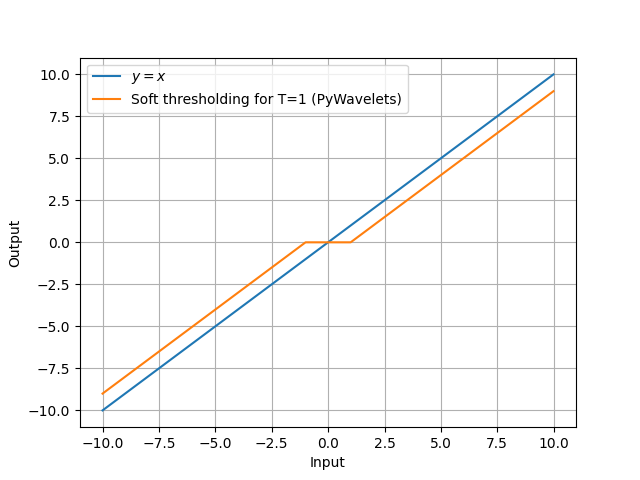

In [107]:
# Set x axis
test = np.arange(-10, 10, 0.01)
# Handle matplotlib objects
plt.close("all"); fig = plt.figure(); ax = plt.gca()
# Plot reference
ax.plot(test, test, label = r'$y=x$')
# Plot soft thresholding
soft_thr_test = pywt.threshold(test, value = 1, mode='soft')
ax.plot(test, soft_thr_test, label = 'Soft thresholding for T=1 (PyWavelets)')
# Set grid and legend
ax.grid(); ax.legend(loc='upper left'); ax.set_xlabel("Input"); ax.set_ylabel("Output"); plt.show()

Now, for **1 point**, code the function `threshold_soft(img, T)`, where the parameters are
* `img`: an image to be thresholded, 
* `T`: the value at which to threshold,

and returns the variable `output`, a NumPy Array of the same size as `img`, where soft thresholding has been applied.

<div class='alert alert-info'>
    
<b>Hint:</b> Try the function <a href='https://numpy.org/doc/stable/reference/generated/numpy.maximum.html'><code>np.maximum</code></a>.
</div>

In [108]:
def threshold_soft(img, T):
    output = np.copy(img)
    
    # YOUR CODE HERE
    output = np.sign(img) * np.maximum(0, np.abs(img)-T)
    
    return output

As a first test on your function, we will try to replicate the previous plot using your function. Run the next cell to see if you get the same results.

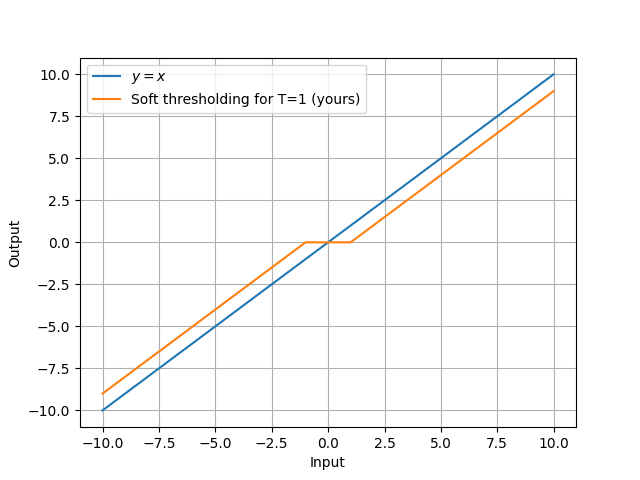

In [109]:
# Set x axis
test = np.arange(-10, 10, 0.01)
# Handle matplotlib objects
plt.close("all"); fig = plt.figure(); ax = plt.gca()
# Plot reference
ax.plot(test, test, label = r'$y=x$')
# Plot soft thresholding
soft_thr = threshold_soft(test, T = 1)
ax.plot(test, soft_thr, label = 'Soft thresholding for T=1 (yours)')
# Set grid and legend
ax.grid(); ax.legend(loc='upper left'); ax.set_xlabel("Input"); ax.set_ylabel("Output"); plt.show()

Now run the next cell to look at the results of your thresholding and of PyWavelets thresholding. Look at the wavelet transform and its inverse. Is soft thresholding a better denoising method than just keeping the LL coefficients? 

For you to explore these issues, we will again use the image `doisneau_noise` with $n = 2$ and an arbitrary threshold of $50$. We will plot
* the noisless image, `doisneau`, as ground truth, 
* the noisy image `doisneau_noise`,
* the reconstruction using your soft thresholding,
* the reconstruction using PyWavelet's soft thresholding,
* the wavelet transform,
* your thresholding of the wavelet transform,
* PyWT's thresholding of the wavelet transform.

<div class = 'alert alert-warning'>

<b>Notes:</b> 
<ul>
<li> We are <b>not</b> suggesting that the value of $50$ is ideal. Rather, we want the effect to be very noticeable. See
    <a href="#2.C.-Optimal-threshold-(1-point)">Section 2.C.</a> to address the question of optimal thresholding.</li>
    
<li> In this particular viewer, we want the effect to be very visual in the wavelet transform. Thus, we apply a colormap. This implies that the statistics, including the histogram, are not representative of the thresholded transforms.</li>
</ul>
</div>

In [110]:
# First we get the WT
transform = lab6.pywt_analysis(doisneau_noise, n = 2, wavelet = 'haar')

# Now we will apply both your and PyWavelet thresholding functions to the transform with an arbitrary threshold
student_thr = threshold_soft(transform, T = 50)
pywt_thr = pywt.threshold(transform, value = 50, mode='soft')

# Get the respective inverse transforms
student_iwt = lab6.pywt_synthesis(student_thr, n = 2, wavelet = 'haar')
pywt_iwt = lab6.pywt_synthesis(pywt_thr, n = 2, wavelet = 'haar')

# Enhance visualization
transform = lab6.map_color(transform, n = 2, color_map = color_map)
student_thr = lab6.map_color(student_thr, n = 2, color_map = color_map)
pywt_thr = lab6.map_color(pywt_thr, n = 2, color_map = color_map)

# Plot
plt.close('all')
image_list =  [doisneau, doisneau_noise, student_iwt, pywt_iwt, transform, student_thr, pywt_thr ]
title_list = ['Noiseless image', 'Noisy image', 'Your reconstruction', "PyWavelets' reconstruction", 'Wavelet transform', 'Your thresholded transform', "PyWavelets' thresholded transform"]
softthr_viewer = viewer(image_list, title = title_list, widgets = True)

Now run the next cell for the comparison with PyWavelets. If your answer is correct, it should not raise an error.

In [111]:
np.testing.assert_array_almost_equal(pywt_thr, student_thr, decimal = 4, err_msg = "Your results and PyWavelet's are not the same.")
print('Congratulations! You are getting really good at wavelets.')

Congratulations! You are getting really good at wavelets.


### 2.B. Hard thresholding (1 point)
[Back to table of contents](#ToC_2_WT)

Hard thresholding is another technique to attenuate the smallest coefficients of the wavelet transform, and thus, get rid of the noise. Unlike soft thresholding technique, hard thresholding **does not** try to preserve the smoothness in the values of the transform. It simply puts to zero all the coefficients with an absolute value smaller than a certain $T$, and leave the ones that are bigger or equal than $T$ untouched, as shown by the following formula:

$$t_{h}(x) =
    \begin{cases}
        0 \mbox{   if   } |x|<\operatorname{T}, \\
        x \mbox{        }\mathrm{otherwise}
     \end{cases}
     $$

Run the next cell to see how this looks when we use PyWavelets `pywt.threshold` function.

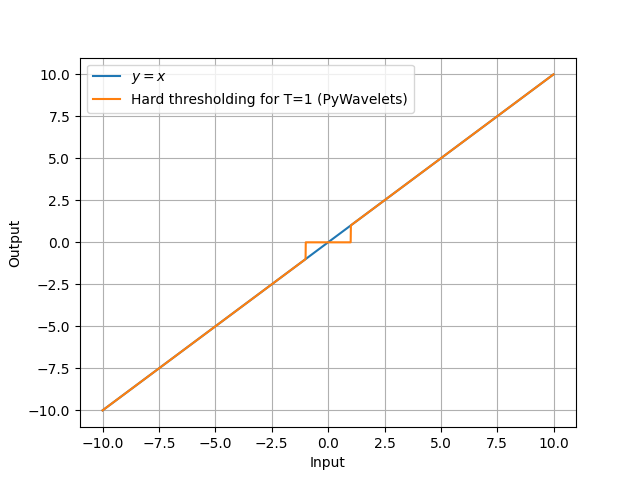

In [112]:
# Set x axis
test = np.arange(-10, 10, 0.01)
# Handle matplotlib objects
plt.close("all"); fig = plt.figure(); ax = plt.gca()
# Plot reference
ax.plot(test, test, label = r'$y=x$')
# Plot soft thresholding
hard_thr_test = pywt.threshold(test, value = 1, mode='hard')
ax.plot(test, hard_thr_test, label = 'Hard thresholding for T=1 (PyWavelets)')
# Set grid and legend
ax.grid(); ax.legend(loc='upper left'); ax.set_xlabel("Input"); ax.set_ylabel("Output"); plt.show()

For **1 point**, code the function `threshold_hard(img, T)`, where the parameters are
* `img`: an image to be thresholded, 
* `T`: the value at which to threshold,

and the function returns
* `output`: an image of the same size as `img`, where hard thresholding has been applied.

<div class = "alert alert-danger">
    
<b>Note</b>: Code the hard threshold in an <i>exclusive</i> way. That is, if a coefficient has absolute value <b>exactly equal to T, it should not be put to zero</b>.
</div>

In [113]:
def threshold_hard(img, T):
    output = np.copy(img)
    
    # YOUR CODE HERE
    output[np.less(np.abs(img), T)] = 0
    
    return output

Now run the next cell, and see if you can recover the lineshape that we showed in the previous plot. 

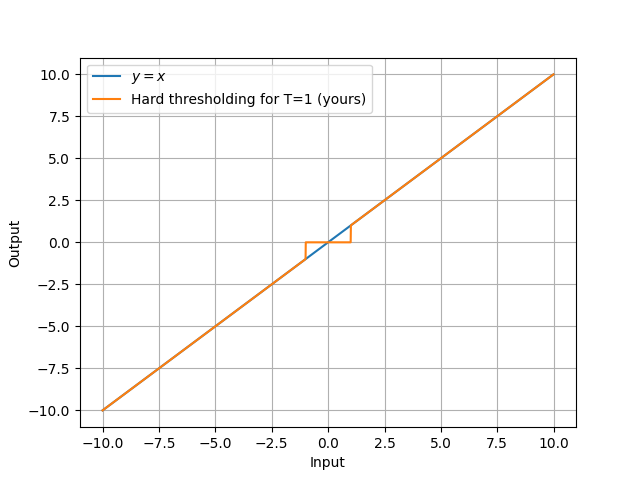

In [114]:
# Set x axis
test = np.arange(-10, 10, 0.01)
# Handle matplotlib objects
plt.close("all"); fig = plt.figure(); ax = plt.gca()
# Plot reference
ax.plot(test, test, label = r'$y=x$')
# Plot hard thresholding
hard_thr_test = threshold_hard(test, T = 1)
ax.plot(test, hard_thr_test, label = 'Hard thresholding for T=1 (yours)')
# Set grid and legend
ax.grid(); ax.legend(loc='upper left'); ax.set_xlabel("Input"); ax.set_ylabel("Output"); plt.show()

We are going to test your function in a similar way as we did for the soft threshold. Run the next cell to apply the hard threshold on the wavelet transform of `doisneau_noise`, with the same parameters as we used for soft thresholding. As with [soft thresholding](#2.A.-Soft-thresholding-(1-point)), we will apply a colormap, and thus, the statistics, including the histogram, are not representative of the thresholded transforms.

In [115]:
# First we get the WT
transform = lab6.pywt_analysis(doisneau_noise, n = 2, wavelet = 'haar')

# Now we will apply both your and PyWavelet thresholding functions to the transform with an arbitrary threshold
student_thr = threshold_hard(transform, T = 50)
pywt_thr = pywt.threshold(transform, value = 50, mode='hard')

# Get the respective inverse transforms
student_iwt = lab6.pywt_synthesis(student_thr, n = 2, wavelet = 'haar')
pywt_iwt = lab6.pywt_synthesis(pywt_thr, n = 2, wavelet = 'haar')

# Enhance visualization
transform = lab6.map_color(transform, n = 2, color_map = color_map)
student_thr = lab6.map_color(student_thr, n = 2, color_map = color_map)
pywt_thr = lab6.map_color(pywt_thr, n = 2, color_map = color_map)

# Plot
plt.close('all')
image_list =  [doisneau, doisneau_noise, student_iwt, pywt_iwt, transform, student_thr, pywt_thr ]
title_list = ['Noiseless image', 'Noisy image', 'Your reconstruction', "PyWT's reconstruction", 'Wavelet transform', 'Your thresholded transform', "PyWT's thresholded transform"]
softthr_viewer = viewer(image_list, title = title_list, widgets = True)

Finally, we are going to compare your function against PyWavelets' on the wavelet transform of `doisneau_noise`. Run the next cell and if it does not throw any error, your implementation is likely correct. 

In [116]:
np.testing.assert_array_almost_equal(pywt_thr, student_thr, decimal = 4, 
                 err_msg = 'Your results and PyWT\'s are not the same. Look for the differences in the viewer above!')
print('Congratulations! You are getting even better at wavelets.')

Congratulations! You are getting even better at wavelets.


### 2.C. Optimal threshold (1 point)
[Back to table of contents](#ToC_2_WT)

As you have probably seen, wavelet denoising can be really powerful. But how would you choose the optimal threshold value $T$? Let's look for a moment at the evolution of the quality of an image as we increase the threshold T. For that, we will leave the real images for a moment and use a toy example, the [Shepp-Logan phantom](https://en.wikipedia.org/wiki/Shepp%E2%80%93Logan_phantom), a standard test for image reconstruction algorithms coming from the field of computerized tomography (CT). We will load this image from skimage's [data](https://scikit-image.org/docs/dev/api/skimage.data.html) module. It has a range of $[0, 1]$, and we will add zero-mean gaussian noise with a standard deviation of $0.2$ (comparably, quite a lot of noise). Then we will denoise with a series of thresholds, and plot the evolution of the SNRs with the threshold. 

Run the next cell to see this test. Browse the images in the viewer, to see how powerful wavelet denoising is!

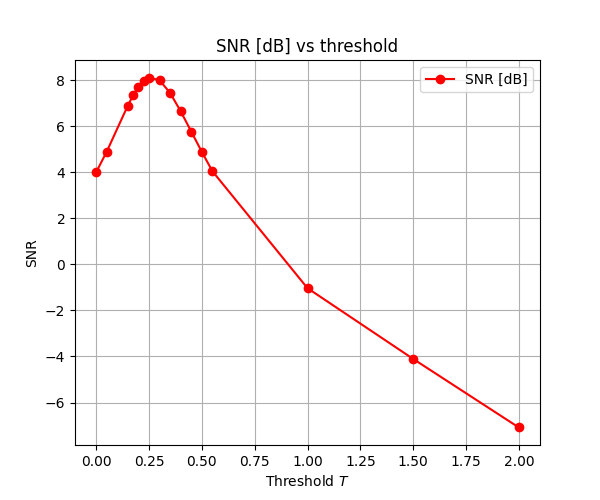

In [117]:
# Load phantom and add noise
phantom = data.shepp_logan_phantom()
noisy_phantom = phantom + np.random.normal(loc=0, scale=0.2, size=phantom.shape)

# Declare function nosie
def denoise(img, T, mode):
    output = np.copy(img)
    # Get WT with arbitrary n=2
    output = lab6.pywt_analysis(output, 2, 'haar')
    # Denoise with given threshold
    output = pywt.threshold(output, value = T, mode=mode)
    # Get iWT
    return lab6.pywt_synthesis(output, 2, 'haar')

# Declare viewer parameters
image_list = [phantom, noisy_phantom]
snr = lab6.snr_db(phantom, noisy_phantom)
title_list = ['Original', f'Noisy (SNR [dB] = {np.round(lab6.snr_db(phantom, noisy_phantom), 2)})']

# Get lists with SNRs and thresholds
snrs = [snr]
thresholds = [0.05, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 1, 1.5, 2]

# Apply denoising
for T in thresholds:
    denoised = denoise(noisy_phantom, T, 'soft')
    image_list.append(denoised)
    snr = lab6.snr_db(phantom, denoised)
    snrs.append(snr)
    title_list.append(f'Denoised with T={T} (SNR [dB] = {np.round(snr, 2)})')

# Visualize images
plt.close('all')
viewer(image_list, title = title_list, widgets=True)

# Plot evolution of SNR with T
plt.figure(figsize = [6, 5])
plt.plot(np.concatenate(([0], thresholds)), snrs, 'r-o', label = 'SNR [dB]')
plt.xlabel(r'Threshold $T$'); plt.ylabel('SNR'); plt.grid()
plt.title('SNR [dB] vs threshold')
plt.legend(); plt.show()

In terms of SNR there is clearly an optimal $T$. A rule of thumb is to choose $T = \sigma_{\mathrm{HH}_1}$ as threshold for the denoising. $\sigma_{\mathrm{HH}_1}$ is the sample standard deviation of the noise in the **largest diagonal highpass band HH**, i.e., in the diagonal highpass band of the first iteration of the transform. This is partly because $T = \sigma_{\mathrm{HH}_1}$ is a good estimator of the true standard deviation $\sigma$ of the noise.

<div class = 'alert = alert-success'>

<b>Note:</b> Did you look closely at the plot above? You can see that the treshold that maximizes the SNR and the standard deviation of the noise of the image <code>noisy_phantom</code> are in the same ballpark. 
</div>

For **1 point**, implement the function `h_std(wt)`, that takes as parameter a wavelet transform in the form we have used in the rest of the lab and returns the rule-of-thumb threshold $T = \sigma_{\mathrm{HH}_1}$. A good test that you can build for yourself in the empty cell below is to take the wavelet transform of the image `noisy_phantom`, apply `h_std` on it and see of you recover something similar to the standard deviation of the noise $\sigma$.

In [118]:
def h_std(wt):
    # Preallocate output variable
    T = 0
    
    # YOUR CODE HERE
    T = np.std(wt[wt.shape[0]//2:, wt.shape[1]//2:])
    
    return T

We will quickly test your function on the image `mit_coef` (which is already a wavelet transform), where we know that the rule-of-thumb threshold is $T = 7.784177$. 

<div class = 'alert alert-info'>

<b>Note:</b> If you want to further test your function, you can use the previous cell to apply it on the wavelet transform of different images. Compare the value you get against the value from <i>ImageViewer</i> (remember that if you zoom into a region, the statistics textbox will automatically update the standard deviation).
</div>

In [119]:
if not np.abs(h_std(mit_coef) - 7.1784177) < 1e-5:
    print(f"WARNING!!\nh_std doesn't return the correct value ({h_std(mit_coef)}).")
print('Nice, your h_std function passed the sanity check.')

Nice, your h_std function passed the sanity check.


So far, we have tested arbitrary thresholds and only in particular cases. In the next cell you will find an ImageViewer with

* a slider to control the value of $T$,
* a checkbox selecting whether to simply set $T$ to its rule-of-thumb value (check off for the aforementioned slider to take effect),
* a slider to control the number of iterations of the transform $n$,
* a dropdown menu to choose a colormap. Note that the `'Normalize std'` option will only appear if you have implemented it in `lab6.py`,
* a dropdown menu to choose the different thresholding operations,
* the button `Apply denoising`, to plot the images resulting from the options you selected.

Remember to go to the menu `Extra Widgets` to see these options. In the viewer, you will see both the original image and the reconstruction.

<div class = "alert alert-info">
    
<b>Note:</b> In order to preserve the visual effect of thresholding, we use colormaps. In order to see it clearly, alternate between $T = 0$ and a given value. If you want to see the effect of thresholding in the histogram too, make sure to set the colormap to <code>None</code>.
</div>

In [120]:
## Sliders
T_slider = widgets.FloatSlider(value = 0, min = 0, max = 200, step = 0.1, description = 'T')
T_checkbox = widgets.Checkbox(description='Optimal T')
n_slider = widgets.IntSlider(value = 1, min = 0, max = 5, step = 1, description = 'n')
## Menus
# Check if you have defined Normalize std in lab6.py, define color map menu accordingly
rand_array = np.random.randn(10,10)
if np.allclose(lab6.norm_std_map(rand_array), rand_array):
    cmapping_dropdown = widgets.Dropdown(description='Colormap', options = ['Non-uniform map', 'None'], value = 'None')
else:
    cmapping_dropdown = widgets.Dropdown(description='Colormap', options = ['Normalize std', 'Non-uniform map', 'None'], value = 'None')
thresh_dropdown = widgets.Dropdown(description='Threshold mode', options = ['Soft', 'Hard'], value = 'Soft')
# Button
button = widgets.Button(description = 'Apply denoising')

def callback_wt(img):
    # Set slider and T with optimal checkbox, or extract slider value
    if T_checkbox.value:
        T = h_std(img)
        T_slider.value = np.round_(T, decimals=1)
    else:
        T = T_slider.value
    # Set n
    n = n_slider.value
    # Compute transform
    transform = lab6.pywt_analysis(img, wavelet = 'haar', n = n)
    # Threshold
    if thresh_dropdown.value == 'Soft':
        transform = pywt.threshold(transform, value = T, mode='soft')
    elif thresh_dropdown.value == 'Hard':
        transform = pywt.threshold(transform, value = T, mode='hard')
    # Return reconstruction
    return lab6.pywt_synthesis(transform, wavelet = 'haar', n = n)

def callback_iwt(img):
    # Set slider and T with optimal checkbox, or extract slider value
    if T_checkbox.value:
        T = h_std(img)
        T_slider.value = np.round_(T, decimals=1)
    else:
        T = T_slider.value
    # Set n
    n = n_slider.value
    # Compute transform
    transform = lab6.pywt_analysis(img, wavelet = 'haar', n = n)
    # Threshold
    if thresh_dropdown.value == 'Soft':
        transform = pywt.threshold(transform, value = T, mode='soft')
    elif thresh_dropdown.value == 'Hard':
        transform = pywt.threshold(transform, value = T, mode='hard')
    # Apply colormap
    if cmapping_dropdown.value == 'Normalize std':
        transform = lab6.map_color(transform, n = n, color_map = lab6.norm_std_map)
    elif cmapping_dropdown.value == 'Non-uniform map':
        transform = lab6.map_color(transform, n = n, color_map = lab6.non_uniform_map)
    return transform

new_widgets = [T_slider, T_checkbox, n_slider, cmapping_dropdown, thresh_dropdown, button]

plt.close('all')
soft_thr_viewer = viewer([doisneau_noise, doisneau_noise], title=['Denoised image','Wavelet transform'], new_widgets=new_widgets, 
                         callbacks=[callback_wt, callback_iwt], hist = True, subplots = [2, 1]) 
T_checkbox.value = True
button.click()

## 3. Compression (2 points)
[Back to table of contents](#ToC_2_WT)

As you saw towards the end of [Lab 1](./1_Wavelet_transform.ipynb), just a few coefficients of the wavelet transform can rebuild an image with a decent SNR. This makes the wavelet transform a great tool for image compression. Simple data compression is achieved by applying a hard threshold to the coefficients of an image transform, as used in JPEG2000 with the wavelet transform or in JPEG with the discrete cosine transform (DCT). Note that this is only a rudimentary form of compression. A true encoder would further quantize the wavelet coefficients, which induces additional errors. The resulting coefficient map would also need to be encoded efficiently using, for example, the EZW algorithm (embedded zero-tree wavelet coding). You can find more information about the EZW algorithm on your [course-notes](https://moodle.epfl.ch/course/view.php?id=463), or if you are really interested in the topic, read [the original article](https://ieeexplore.ieee.org/abstract/document/258085).

For **1 point**, code the function `compress`, that **retains a specific percentage of the wavelet coefficients** (the ones with largest **absolute values**), and sets all the other ones to $0$. The parameters are
* `wt`: the wavelet transform of an image,
* `per`: the percentage of coefficients to be retained (in integer percentages, e.g., $10$ instead of $0.1$ to specify $10\%$),

and returns
* `output`: an array of the same size as `wt`, containing wavelet coefficients where **hard thresholding has been applied** (you are allowed to use `pywt.threshold` if you so wish),
* `T`: the threshold value,
* `r`: the **ratio** of non-zero pixels in `output`.

<div class = "alert alert-info">
    
<b>Note</b>: You might find the function [<code>np.percentile</code>](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) useful.
</div>

<div class = "alert alert-danger">

<b>Note</b>: Use the function [<code>np.count_nonzero</code>](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html) to calculate the ratio of non-zero coefficients.
</div>

In [147]:
def compress(wt, per):
    output = np.copy(wt)
    T = None
    r = None
    
    # YOUR CODE HERE
    T = np.max(np.abs(wt)) * (100 - per) / 100
    output = pywt.threshold(wt, value=T, mode='hard', substitute=0)

    r = np.count_nonzero(output) / len(output)
    
    return output, T, r

For a quick test on your function, we will not use an image, but an axis in the range $[-10, 10]$, like the ones we used to demonstrate the thresholding functions. 

Run the next cell to test your function, which will show the curves for different percentages of kept values. Note that since we have evenly spread values from $-10$ to $10$, it is easy to verify the correctness of your function.

Kept 10% of coeff.s with threshold 9.00 and compression ratio 0.1
Kept 20% of coeff.s with threshold 8.00 and compression ratio 0.2
Kept 30% of coeff.s with threshold 7.00 and compression ratio 0.3
Kept 40% of coeff.s with threshold 6.00 and compression ratio 0.4
Kept 50% of coeff.s with threshold 5.00 and compression ratio 0.5


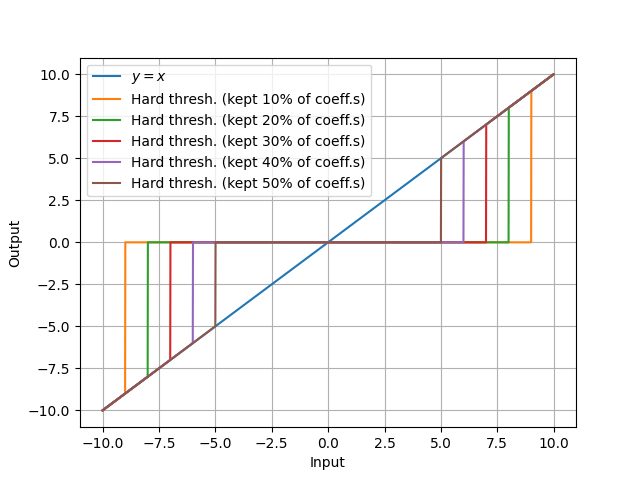

In [148]:
# Set x axis
test = np.arange(-10, 10, 0.01)
# Handle matplotlib objects
plt.close("all"); fig = plt.figure(); ax = plt.gca()
# Plot reference
ax.plot(test, test, label = r'$y=x$')
# Plot hard thresholding for different percentiles
for i, per in enumerate([10,20,30,40,50]):
    hard_thr_test, T, r = compress(test, per = per)
    ax.plot(test, hard_thr_test, label = f'Hard thresh. (kept {per}% of coeff.s)')
    print(f"Kept {per}% of coeff.s with threshold {T:.2f} and compression ratio {r}")
    if not np.isclose(T, 9-i):
        if np.isclose(T, i+1):
            print(f"\n###\nBe careful with how are you calculating your threshold!\nYou need to KEEP {per}\
% of coefficients, as opposed to discarding {per}% of them\n###\n")
        else:
            print(f"###\nBe careful with how are you calculating your threshold!\n###")
# Set grid and legend
ax.grid(); ax.legend(loc='upper left'); ax.set_xlabel("Input"); ax.set_ylabel("Output"); plt.show()


Verify that both the threshold and the number of remaining pixels make sense. Now, let's take a look at your function applied to the image `mer_de_glace`, where we will keep only $5\%$ of the coefficients. 

Run the next cell to see the image `mer_de_glace`, its wavelet transform, its reconstruction after wavelet compression, and the thresholded wavelet transform. To enhance visualization, we will also use the colormap you selected on the wavelet transforms. Observe that while the reconstructed image looks quite good at first, zooming in reveals many compression artifacts (after all, $5\%$ of the coefficients is not much). To better compare the images, feel free to use `Options` $\rightarrow$ `Enable Joint Zoom` in the viewer.

In [149]:
# Get the wavelet transform
wt = lab6.pywt_analysis(mer_de_glace, wavelet = 'haar', n = 4)

# Apply compression (keeping 5% of the coefficients)
compressed_wt, T, r = compress(wt, per = 5)

# Reconstruct each and calculate SNR
compressed_rec = lab6.pywt_synthesis(compressed_wt, wavelet = 'haar', n = 4)
snr_comp = np.round_(lab6.snr_db(compressed_rec, mer_de_glace), decimals = 2)

# Apply colormap for better visualization
wt =            lab6.map_color(wt,            n = 4, color_map = color_map)
compressed_wt = lab6.map_color(compressed_wt, n = 4, color_map = color_map)

image_list = [mer_de_glace, wt, compressed_rec, compressed_wt]
title_list = ['Original', 'Wavelet transform (n=4)', 
              f'Compressed rec. (SNR [dB] = {snr_comp})',
              f'Compressed wavelet tr. (T = {np.round_(T, decimals = 2)})']

plt.close('all')
compression_viewer = viewer(image_list, title = title_list, subplots=(3,2))

Button(description='Show Widgets', style=ButtonStyle())

### Multiple Choice Question
[Back to table of contents](#ToC_2_WT)

Now at this point you may be asking yourself, why do we put compression and denoising in a different category, if we use thresholding anyway? For **1 point** answer the following. 

* Q1. Assume we calculate, with respect to `doisneau`, the **SNR** of `doisneau_noise`, of `doisneau_noise` after optimal denoising, and of `doisneau_noise` after compression **keeping only $2\%$ of the coefficients**. What will be the order of the SNRs, from low to high?

1. `doisneau_noise` < `doisneau_noise` after optimal denoising < `doisneau_noise` after compression 
2. `doisneau_noise` < `doisneau_noise` after compression < `doisneau_noise` after optimal denoising
3. `doisneau_noise` after optimal denoising < `doisneau_noise` < `doisneau_noise` after compression
4. `doisneau_noise` after optimal denoising < `doisneau_noise` after compression < `doisneau_noise`
5. `doisneau_noise` after compression < `doisneau_noise` < `doisneau_noise` after optimal denoising
6. `doisneau_noise` after compression < `doisneau_noise` after optimal denoising < `doisneau_noise`

Modify the variable answer in the following cell to reflect your choice. 
<div class = 'alert alert-info'>
    
<b>Note</b>: If you want to verify your answer, you can use the empty cell below to experiment. Recycle any code you need!
</div>

In [151]:
# Assign your answer to this variable
answer = 5
# YOUR CODE HERE

In [152]:
# Sanity check
if not answer in [1, 2, 3, 4, 5, 6]:
    print('WARNING!!\nValid answers are 1, 2, 3, 4, 5 or 6.')

As you can see, it is quite remarkable how sparse can the wavelet transform be before we start to loose information. This makes compression and denoising two huge applications, and makes the wavelet transform an important tool in image processing. If you want to finish exploring the potential of the methods we have seen, and in particular, understand the boundaries of denoising and compression, play around with the following cell! We have included a widget where you can:

* Create a noisy image, 
* Denoise/compress keeping a specific percentage of coefficients.

Run the next cell and go to the menu `Extra Widgets` to explore the applications of the wavelet transform! You can choose which image you want to use by changing the first line of the cell.

In [153]:
# Choose image
image = mer_de_glace
## Declare sliders
noise_std_slider = widgets.FloatSlider(value = 20, min = 0, max = 40, step = 0.1, description = r'Noise $\sigma$')
noise_mean_slider = widgets.FloatSlider(value = 0, min = -100, max = 100, step = 0.1, description = 'Noise mean')
per_slider = widgets.FloatSlider(value = 100, min = 0, max = 100, step = 0.1, description = '% of coeff.s')
n_slider = widgets.IntSlider(value = 1, min = 0, max = 5, step = 1, description = 'n')
# Button % Optimal threshold checkbox
T_checkbox = widgets.Checkbox(description='Optimal T')
button = widgets.Button(description = 'Apply')

# Declare callbacks
def callback_noise(img):
    # Get noise
    mean = noise_mean_slider.value
    std = noise_std_slider.value
    # Return noisy image
    return img + np.random.normal(mean, std, img.shape)

def callback_iwt(img):
    # Build noisy image
    mean = noise_mean_slider.value
    std = noise_std_slider.value
    noisy = img + np.random.normal(mean, std, img.shape)
    
    # Set n
    n = n_slider.value
    # Set percentage
    per = per_slider.value
    
    # Compute transform
    transform = lab6.pywt_analysis(noisy, wavelet = 'haar', n = n)
    # Threshold
    if T_checkbox.value:
        T = h_std(transform)
        transform = pywt.threshold(transform, value = T, mode = 'soft')
    else:
        transform, T, _ = compress(transform, per)
    # Return iWT
    return lab6.pywt_synthesis(transform, wavelet = 'haar', n = n)

# Viewer Parameters
new_widgets = [noise_std_slider, noise_mean_slider, n_slider, per_slider, T_checkbox, button]

plt.close('all')
compression_viewer = viewer([image, image], title=['Noisy Image', 'Reconstruction'], new_widgets=new_widgets, 
                         callbacks=[callback_noise, callback_iwt], subplots = [2, 1], widgets = True) 
button.click()

<div class="alert alert-success">

<p><b>You have reached the end of the second part of the Wavelets lab!</b></p>
<p>
Make sure to save your notebook (you might want to keep a copy on your personal computer) and upload it to <a href="https://moodle.epfl.ch/mod/assign/view.php?id=1148687">Moodle</a>, in a zip file with other notebooks of this lab.
</p>
</div>

* Keep the name of the notebook as: *1_Wavelet_transform.ipynb*,
* Name the zip file: *Wavelets_lab.zip*.

<div class="alert alert-danger">
<h4>Feedback</h4>
    <p style="margin:4px;">
    This is the first edition of the image-processing laboratories using Jupyter Notebooks running on Noto. Do not leave before giving us your <a href="https://moodle.epfl.ch/mod/feedback/view.php?id=1148686">feedback here!</a></p>
</div>